In [1]:
import numpy as np
from matplotlib import pyplot as plt
from pprint import pprint
np.set_printoptions(precision=4, linewidth=120, floatmode='maxprec_equal')

In [2]:
import pygsti
import pygsti.extras.interpygate as interp
from pygsti.tools.basistools import change_basis
from pygsti.modelpacks import smq1Q_XY

In [3]:
from pathlib import Path
working_dir = Path.cwd()

## Build model gate

In [4]:
sigI = np.array([[1.,0],[0, 1]], dtype='complex')
sigX = np.array([[0, 1],[1, 0]], dtype='complex')
sigY = np.array([[0,-1],[1, 0]], dtype='complex') * 1.j
sigZ = np.array([[1, 0],[0,-1]], dtype='complex')
sigM = (sigX - 1.j*sigY)/2.
sigP = (sigX + 1.j*sigY)/2.

In [5]:
class SingleQubitTargetOp(pygsti.modelmembers.operations.OpFactory):

    def __init__(self):
        self.process = self.create_target_gate
        pygsti.modelmembers.operations.OpFactory.__init__(self, 1, evotype="densitymx")
        self.dim = 4

    def create_target_gate(self, v):
        
        phi, theta = v
        target_unitary = (np.cos(theta/2) * sigI + 
                          1.j * np.sin(theta/2) * (np.cos(phi) * sigX + np.sin(phi) * sigY))
        superop = change_basis(np.kron(target_unitary.conj(), target_unitary), 'col', 'pp')

        return superop
    
    def create_object(self, args=None, sslbls=None):
        assert(sslbls is None)
        mx = self.process([*args])
        return pygsti.modelmembers.operations.StaticArbitraryOp(mx)

In [6]:
class SingleQubitGate(interp.PhysicalProcess):
    def __init__(self, 
                 verbose=False,
                 cont_param_gate = False,
                 num_params = None,
#                  process_shape = (4, 4),
                 item_shape = (4,4),
                 aux_shape = None,
                 num_params_evaluated_as_group = 0,
                 basis = 'pp'):

        self.verbose = verbose

        self.cont_param_gate = cont_param_gate

        self.num_params = num_params
        self.item_shape = item_shape

        self.aux_shape = aux_shape
        self.num_params_evaluated_as_group = num_params_evaluated_as_group
        self.basis = basis
   
    def create_process_matrix(self, v, comm=None, return_generator=False):                                                                                                                                                                                             

        processes = []
        phi, theta, t = v
        theta = theta * t
        target_unitary = (np.cos(theta/2) * sigI + 
                          1.j * np.sin(theta/2) * (np.cos(phi) * sigX + np.sin(phi) * sigY))
        superop = change_basis(np.kron(target_unitary.conj(), target_unitary), 'col', 'pp')
        processes += [superop]
        return np.array(processes) if (processes is not None) else None

    def create_aux_info(self, v, comm=None):
        return []  # matches aux_shape=() above
    
    def create_process_matrices(self, v, grouped_v, comm=None):
        assert(len(grouped_v) == 1)  # we expect a single "grouped" parameter

        processes = []
        times = grouped_v[0]
        phi_in, theta_in = v
        for t in times:
            phi = phi_in
            theta = theta_in * t
            target_unitary = (np.cos(theta/2) * sigI + 
                              1.j * np.sin(theta/2) * (np.cos(phi) * sigX + np.sin(phi) * sigY))
            superop = change_basis(np.kron(target_unitary.conj(), target_unitary), 'col', 'pp')
            processes += [superop]
        return np.array(processes) if (processes is not None) else None

    def create_aux_infos(self, v, grouped_v, comm=None):
        import numpy as np
        times = grouped_v[0]
        return [ [] for t in times] # list elements must match aux_shape=() above

In [7]:
param_ranges = [(0.9,1.1,3)]

arg_ranges = [2*np.pi*(1+np.cos(np.linspace(np.pi,0, 7)))/2,
              (0, np.pi, 3)] 
arg_indices = [0,1]


target_op = SingleQubitTargetOp()
gate_process = SingleQubitGate(num_params = 3,num_params_evaluated_as_group = 1)

In [8]:
opfactory_linear = interp.InterpolatedOpFactory.create_by_interpolating_physical_process(
    target_op, gate_process, argument_ranges=arg_ranges, parameter_ranges=param_ranges, 
    argument_indices=arg_indices, interpolator_and_args='linear')

opfactory_spline = interp.InterpolatedOpFactory.create_by_interpolating_physical_process(
    target_op, gate_process, argument_ranges=arg_ranges, parameter_ranges=param_ranges, 
    argument_indices=arg_indices, interpolator_and_args='spline')


/Users/kyoung/Documents/Research/dev/venvs/pygsti_interpygate/lib/pyGSTi/pygsti/extras/interpygate/core.py:675: ComplexWarning: Casting complex values to real discards the imaginary part
  data[ind] = val     # (other procs can just return None, so val = None)


In [9]:
type(opfactory_linear)

pygsti.extras.interpygate.core.InterpolatedOpFactory

### Check that the interpolator is working

In [10]:
if False:
    indices = (2,3)
    nparams = 30

    x = np.linspace(0,2*np.pi, nparams)
    y = np.linspace(0, np.pi, nparams)
    for p in np.linspace(.9,1.1,5):

        def interp_linear(x, y):    
            op = opfactory_linear.create_op([x, y])
            return op.base_interpolator([x,y,p])[indices]

        def interp_spline(x, y):    
            op = opfactory_spline.create_op([x, y])
            return op.base_interpolator([x,y,p])[indices]

        def truth(x, y):
            tmp_gate = gate_process.create_process_matrix([x,y,p])[0]
            tar_gate = target_op.create_target_gate([x,y])
            return pygsti.error_generator(tmp_gate, tar_gate, 'pp', 'logGTi')[indices]


        X, Y = np.meshgrid(x, y, indexing='ij')
        Z_linear = np.zeros([nparams, nparams])
        Z_spline = np.zeros([nparams, nparams])
        Z_truth  = np.zeros([nparams, nparams])
        for idx, xx in enumerate(x):
            for idy, yy in enumerate(y):
                Z_linear[idx,idy] = interp_linear(xx,yy)
                Z_spline[idx,idy] = interp_spline(xx,yy)
                Z_truth[idx,idy]  = truth(xx,yy)

        fig = plt.figure(figsize=(10,10))
        ax = plt.axes(projection='3d')

        ax.plot_surface(X, Y, Z_linear-Z_truth, rstride=1, cstride=1,
                        edgecolor='none', alpha=.8)
        ax.plot_surface(X, Y, Z_spline-Z_truth, rstride=1, cstride=1,
                        cmap='viridis', edgecolor='none', alpha=.8)

        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
    #     ax.set_zlim(-1,1)
        plt.show()

# Build a model from this gate

In [11]:
x_gate = opfactory_spline.create_op([0,np.pi/4])
y_gate = opfactory_spline.create_op([np.pi/2,np.pi/4])

In [12]:
x_gate.from_vector([1.03])
y_gate.from_vector([1.0])
print(np.round_(x_gate,4))
print()
print(np.round_(y_gate,4))

[[ 1.0000  0.0000  0.0000  0.0000]
 [ 0.0000  1.0000  0.0000  0.0000]
 [ 0.0000  0.0000  0.6902  0.7236]
 [ 0.0000  0.0000 -0.7236  0.6902]]

[[ 1.0000  0.0000 -0.0000  0.0000]
 [-0.0000  0.7071  0.0000 -0.7071]
 [ 0.0000  0.0000  1.0000  0.0000]
 [ 0.0000  0.7071 -0.0000  0.7071]]


In [13]:
x_gate.parameter_bounds = np.array([[0.91, 1.09]])
y_gate.parameter_bounds = np.array([[0.91, 1.09]])

## Make a fake dataset

In [14]:
#Model only has Gx and Gy gates.  Let's rename them.

model = pygsti.models.ExplicitOpModel([0],'pp')

model['rho0'] = [ 1/np.sqrt(2), 0, 0, 1/np.sqrt(2) ] # density matrix [[1, 0], [0, 0]] in Pauli basis
model['Mdefault'] = pygsti.modelmembers.povms.UnconstrainedPOVM(
    {'0': [ 1/np.sqrt(2), 0, 0, 1/np.sqrt(2) ],   # projector onto [[1, 0], [0, 0]] in Pauli basis
     '1': [ 1/np.sqrt(2), 0, 0, -1/np.sqrt(2) ] }, evotype="default") # projector onto [[0, 0], [0, 1]] in Pauli basis
model['Gxpi2',0] = x_gate
model['Gypi2',0] = y_gate

In [15]:
model.num_params

14

In [16]:
# Define the error model used to generate data
datagen_model = model.copy()
datagen_params = datagen_model.to_vector()
datagen_params[-2:] = [1.03,1.00]
datagen_model.from_vector(datagen_params)
datagen_model.probabilities( (('Gxpi2',0),('Gypi2',0),))

OutcomeLabelDict([(('0',), 0.7440309049146735), (('1',), 0.2559690950853263)])

In [17]:
model.parameter_labels

array([(Label('rho0'), 'VecElement Re(0)'), (Label('rho0'), 'VecElement Re(1)'), (Label('rho0'), 'VecElement Re(2)'),
       (Label('rho0'), 'VecElement Re(3)'), (Label('Mdefault'), 'VecElement Re(0)'),
       (Label('Mdefault'), 'VecElement Re(1)'), (Label('Mdefault'), 'VecElement Re(2)'),
       (Label('Mdefault'), 'VecElement Re(3)'), (Label('Mdefault'), 'VecElement Re(0)'),
       (Label('Mdefault'), 'VecElement Re(1)'), (Label('Mdefault'), 'VecElement Re(2)'),
       (Label('Mdefault'), 'VecElement Re(3)'), (Label(('Gxpi2', 0)), 'Unknown param 0'),
       (Label(('Gypi2', 0)), 'Unknown param 0')], dtype=object)

In [18]:
# # Link the over-rotation errors on Gx and Gy
#model.collect_parameters(model.parameter_labels[-2:], 'Shared Gx/Gy physical parameter')
#print(model.parameter_labels)
print(model.num_params)

# # Define the error model used to generate data
# datagen_model = model.copy()
# datagen_params = datagen_model.to_vector()
# datagen_params[-1:] = [1.02]
# datagen_model.from_vector(datagen_params)
# datagen_model.probabilities( (('Gxpi2',0),('Gypi2',0),))

14


In [19]:
# Define the perfect target model
target_model = model.copy()
target_params = target_model.to_vector()
target_params[-2:] = [1,1]
# target_model.from_vector(target_params)
target_model.probabilities( (('Gxpi2',0),('Gypi2',0),))

OutcomeLabelDict([(('0',), 0.7440309049146735), (('1',), 0.2559690950853263)])

### Germ and fiducial selection

In [20]:
final_germs = pygsti.algorithms.germselection.find_germs(
                target_model, randomize=False, force=None, algorithm='greedy', 
                verbosity=4, num_nongauge_params=2)

Initial Length Available Germ List: 23
Length Available Germ List After Deduping: 23
Length Available Germ List After Dropping Random Fraction: 23
Memory estimate of 0.0 GB for all-Jac mode.
Memory estimate of 0.0 GB for single-Jac mode.
Using greedy algorithm.
Number of gauge parameters: 12
Number of non-gauge parameters: 2
Memory estimate of 0.0 GB for all-Jac mode.
Memory estimate of 0.0 GB for single-Jac mode.
Complete initial germ set succeeds on all input models.
Now searching for best germ set.
Starting germ set optimization. Lower score is better.
  Numpy Array Data Type: complex128
  Numpy array data type for twirled derivatives is: complex128 If this isn't what you specified then something went wrong.
  Outer iteration: 1 of 2 amplified, 0 germs
  Inner iter over candidate germs Iter 01 of 23 Gxpi2:0@(0): 
  Inner iter over candidate germs Iter 02 of 23 Gypi2:0@(0): 
  Inner iter over candidate germs Iter 03 of 23 Gxpi2:0Gypi2:0@(0): 
  Inner iter over candidate germs Iter 04

In [21]:
fiducial_pairs = pygsti.algorithms.fiducialpairreduction.find_sufficient_fiducial_pairs_per_germ(
                                model, 
                                smq1Q_XY.prep_fiducials(),
                                smq1Q_XY.meas_fiducials(), 
                                final_germs)

In [22]:
# # Reduce the number of fiducial pairs by hand, if you want

# fiducial_pairs2 = fiducial_pairs.copy()
# for key in fiducial_pairs2.keys():
#     fiducial_pairs2[key] = fiducial_pairs2[key][0:2]
# fiducial_pairs = fiducial_pairs2

# print(fiducial_pairs)

In [23]:
# Use fiducial pair reductions
exp_design = pygsti.protocols.StandardGSTDesign(model, 
                                                smq1Q_XY.prep_fiducials(), 
                                                smq1Q_XY.meas_fiducials(), 
                                                final_germs, 
                                                max_lengths=[1,2,4,8,16,32,64,128,256], 
                                                fiducial_pairs=fiducial_pairs,
                                                include_lgst=False)

dataset = pygsti.data.simulate_data(datagen_model, exp_design.all_circuits_needing_data,
                                    num_samples=1000, seed=1234)

data = pygsti.protocols.ProtocolData(exp_design, dataset)

/Users/kyoung/Documents/Research/dev/venvs/pygsti_interpygate/lib/pyGSTi/pygsti/protocols/gst.py:265: UserWarning: Given model failed to create a processor spec for StdGST experiment design!
  _warnings.warn("Given model failed to create a processor spec for StdGST experiment design!")


In [24]:
len(data.dataset)

54

## Fisher information matrix

In [25]:
fim = pygsti.tools.edesigntools.calculate_fisher_information_matrix(model,
                                                                    exp_design.all_circuits_needing_data)

In [26]:
np.log(np.linalg.inv(fim))

/var/folders/05/42d4jfz15870xr0c6hjc_c800026_n/T/ipykernel_28989/1867990375.py:1: RuntimeWarning: invalid value encountered in log
  np.log(np.linalg.inv(fim))


array([[ -4.6821, -35.7964,      nan,  -4.6831, -36.5502, -36.3732,      nan, -34.8380,      nan, -40.8147, -38.8576,
             nan, -42.3144, -40.4273],
       [-36.4592,      nan,  -3.9925,  -2.2600,      nan,      nan,  -3.1437,      nan,  -4.0221,      nan,  -5.8737,
         -2.4551,      nan,      nan],
       [     nan,  -3.9925,  -2.9301,      nan,  -5.8227,  -4.4764,  -3.3587,  -2.6634,      nan,  -5.5915,      nan,
             nan,      nan,  -8.4140],
       [ -4.6831,  -2.2600,      nan,      nan,  -2.9565,  -2.9226,      nan,  -1.2843,      nan,  -5.0098,  -4.8720,
             nan,  -8.8423,  -6.7621],
       [-37.1522,      nan,  -5.8227,  -2.9565,  -4.0587,      nan,  -4.6441,      nan,  -6.6871,  -3.8383,  -4.4721,
         -2.9887,      nan, -10.0110],
       [-37.1286,      nan,  -4.4764,  -2.9226,      nan,  -3.4414,  -3.5031,      nan,  -3.6720,      nan,      nan,
         -3.5654,  -9.4105,      nan],
       [     nan,  -3.1437,  -3.3587,      nan,  -4.6441, 

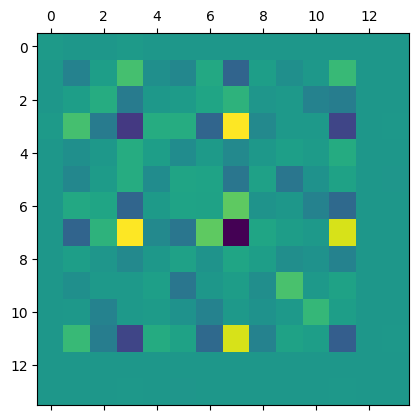

In [27]:
plt.matshow(np.linalg.inv(fim))

# Run GST on the dataset

In [28]:
proto = pygsti.protocols.GateSetTomography(model, gaugeopt_suite=None)
results = proto.run(data)

--- Iterative GST: Iter 1 of 9  6 circuits ---: 
  MatrixLayout: 1 processors divided into 1 x 1 (= 1) grid along circuit and parameter directions.
     1 atoms, parameter block size limits (None,)
  *** Distributing 1 atoms to 1 atom-processing groups (1 cores) ***
      More atom-processors than hosts: each host gets ~1 atom-processors
      Atom-processors already occupy a single node, dividing atom-processor into 1 param-processors.
  *** Divided 1-host atom-processor (~1 procs) into 1 param-processing groups ***
  --- chi2 GST ---
  Sum of Chi^2 = 0.00354097 (6 data params - 14 (approx) model params = expected mean of -8; p-value = nan)
  Completed in 0.1s
  Iteration 1 took 0.1s
  
--- Iterative GST: Iter 2 of 9  12 circuits ---: 
  MatrixLayout: 1 processors divided into 1 x 1 (= 1) grid along circuit and parameter directions.
     1 atoms, parameter block size limits (None,)
  *** Distributing 1 atoms to 1 atom-processing groups (1 cores) ***
      More atom-processors than hos

In [29]:
# What is the estimated value of the error parameter?

final_model = results.estimates['GateSetTomography'].models['final iteration estimate']
print('Actual: ', datagen_model.to_vector()[-2:])
print('Estimated: ', final_model.to_vector()[-2:])

Actual:  [1.03 1.00]
Estimated:  [1.0303 1.0003]


In [30]:
pprint(np.sqrt(2)*final_model.to_vector()[0:4])
pprint(np.sqrt(2)*final_model.to_vector()[4:8])
pprint(np.sqrt(2)*final_model.to_vector()[8:12])

array([ 1.0011, -0.0056,  0.0060,  1.0006])
array([ 1.0033, -0.0246,  0.0086,  1.0026])
array([ 0.9978,  0.0204, -0.0169, -0.9982])
